In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import minimize
import seaborn as sns
from datetime import datetime, timedelta

# Define stock tickers
techassets = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'META', 'TSLA', 'NVDA']
bankingassets = ['BRK-B', 'JPM', 'V', 'BAC', 'AXP', 'GS', 'BLK', 'STT']
healthcareassets = ['LLY', 'JNJ', 'ABT', 'MDT', 'UNH', 'PFE', 'CVS', 'MRK']
all_assets = techassets + bankingassets + healthcareassets

# Define sectors dictionary for later use
sectors = {
    'Technology': techassets,
    'Banking': bankingassets,
    'Healthcare': healthcareassets
}

# Define date range
start_date = '2014-01-01'
end_date = '2025-02-23'  # Set to current date

# Fetch stock data using yfinance
stock_data = {}
failed_downloads = []
for ticker in all_assets:
    try:
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
        print(f'Successfully downloaded data for {ticker}')
    except Exception as e:
        print(f'Failed to download data for {ticker}: {e}')
        failed_downloads.append(ticker)

# Remove failed tickers from the list
all_assets = [ticker for ticker in all_assets if ticker not in failed_downloads]

# Fetch S&P 500 data for benchmark comparison
try:
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
    print('Successfully downloaded data for S&P 500')
except Exception as e:
    print(f'Failed to download data for S&P 500: {e}')

# Check if 'Adj Close' column exists for each ticker and handle missing columns
for ticker in all_assets:
    if 'Adj Close' not in stock_data[ticker].columns:
        stock_data[ticker]['Adj Close'] = stock_data[ticker]['Close']

# Combine data into a single DataFrame
combined_data = pd.concat([stock_data[ticker][['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']] for ticker in all_assets], axis=1)
combined_data.columns = pd.MultiIndex.from_product([all_assets, ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']])

# Calculate daily returns and add them to the combined_data DataFrame
daily_returns = {}
for ticker in all_assets:
    daily_returns[(ticker, 'Daily Return')] = combined_data[(ticker, 'Close')].pct_change()
daily_returns_df = pd.DataFrame(daily_returns)

# Calculate moving averages and add them to the combined_data DataFrame
moving_averages_50 = {}
moving_averages_200 = {}
for ticker in all_assets:
    moving_averages_50[(ticker, '50 Day MA')] = combined_data[(ticker, 'Close')].rolling(window=50).mean()
    moving_averages_200[(ticker, '200 Day MA')] = combined_data[(ticker, 'Close')].rolling(window=200).mean()
moving_averages_50_df = pd.DataFrame(moving_averages_50)
moving_averages_200_df = pd.DataFrame(moving_averages_200)

# Calculate volatility (standard deviation of returns) and add to the combined_data DataFrame
volatility = {}
for ticker in all_assets:
    volatility[(ticker, 'Volatility')] = daily_returns_df[(ticker, 'Daily Return')].rolling(window=50).std()
volatility_df = pd.DataFrame(volatility)

# ENHANCEMENT 3: Add Technical Indicators
def add_technical_indicators(df):
    tech_indicators = {}
    
    for ticker in all_assets:
        close_prices = df[(ticker, 'Close')]
        
        # RSI (Relative Strength Index) - 14-day period
        delta = close_prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        tech_indicators[(ticker, 'RSI')] = 100 - (100 / (1 + rs))
        
        # MACD (Moving Average Convergence Divergence)
        ema12 = close_prices.ewm(span=12, adjust=False).mean()
        ema26 = close_prices.ewm(span=26, adjust=False).mean()
        tech_indicators[(ticker, 'MACD')] = ema12 - ema26
        tech_indicators[(ticker, 'MACD_Signal')] = tech_indicators[(ticker, 'MACD')].ewm(span=9, adjust=False).mean()
        
        # Bollinger Bands (20-day, 2 std dev)
        typical_price = (df[(ticker, 'High')] + df[(ticker, 'Low')] + df[(ticker, 'Close')]) / 3
        rolling_mean = typical_price.rolling(window=20).mean()
        rolling_std = typical_price.rolling(window=20).std()
        tech_indicators[(ticker, 'BB_Upper')] = rolling_mean + (rolling_std * 2)
        tech_indicators[(ticker, 'BB_Lower')] = rolling_mean - (rolling_std * 2)
        tech_indicators[(ticker, 'BB_Width')] = (tech_indicators[(ticker, 'BB_Upper')] - tech_indicators[(ticker, 'BB_Lower')]) / rolling_mean
        
        # ATR (Average True Range) - Volatility indicator
        high_low = df[(ticker, 'High')] - df[(ticker, 'Low')]
        high_close = np.abs(df[(ticker, 'High')] - df[(ticker, 'Close')].shift())
        low_close = np.abs(df[(ticker, 'Low')] - df[(ticker, 'Close')].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = np.max(ranges, axis=1)
        tech_indicators[(ticker, 'ATR')] = true_range.rolling(14).mean()
        
        # OBV (On-Balance Volume)
        obv = np.where(close_prices > close_prices.shift(1), df[(ticker, 'Volume')], 
                       np.where(close_prices < close_prices.shift(1), -df[(ticker, 'Volume')], 0)).cumsum()
        tech_indicators[(ticker, 'OBV')] = pd.Series(obv, index=close_prices.index)
    
    return pd.DataFrame(tech_indicators)

# Add technical indicators
tech_indicators_df = add_technical_indicators(combined_data)

# ENHANCEMENT 10: Identify Market Regimes
def identify_market_regime(returns, window=60):
    """Identify market regime based on volatility"""
    rolling_vol = returns.rolling(window=window).std() * np.sqrt(252)
    regime = pd.cut(rolling_vol, 
                  bins=[0, 0.1, 0.2, 0.3, np.inf], 
                  labels=['Low Vol', 'Normal', 'High Vol', 'Crisis'])
    return regime

# Calculate overall market returns and identify regime
market_returns = daily_returns_df.mean(axis=1)
market_regime = identify_market_regime(market_returns)
market_regime_df = pd.DataFrame(market_regime, columns=['Market Regime'])

# Add market regime to our data
market_regime_column = pd.DataFrame({('Market', 'Regime'): market_regime})

# Concatenate all additional metrics
combined_data = pd.concat([combined_data, daily_returns_df, moving_averages_50_df, 
                           moving_averages_200_df, volatility_df, tech_indicators_df, 
                           market_regime_column], axis=1)

# Drop any rows with NaN values due to rolling calculations
combined_data.dropna(inplace=True)

# Check shape of the data before normalization
print("Shape of combined_data.xs('Close', axis=1, level=1):", combined_data.xs('Close', axis=1, level=1).shape)
print("Columns of combined_data.xs('Close', axis=1, level=1):", combined_data.xs('Close', axis=1, level=1).columns)
print("Length of all_assets:", len(all_assets))

# Calculate expected returns and covariance matrix
returns = combined_data.xs('Daily Return', axis=1, level=1)
mean_returns = returns.mean()
cov_matrix = returns.cov()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AAPL
Successfully downloaded data for MSFT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for GOOG



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AMZN


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ORCL
Successfully downloaded data for META


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for TSLA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for NVDA
Successfully downloaded data for BRK-B


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for JPM


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for V


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for BAC


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AXP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for GS


Successfully downloaded data for BLK


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for STT


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for LLY


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for JNJ


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ABT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for MDT
Successfully downloaded data for UNH


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for PFE


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for CVS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for MRK
Successfully downloaded data for S&P 500
Shape of combined_data.xs('Close', axis=1, level=1): (2603, 24)
Columns of combined_data.xs('Close', axis=1, level=1): Index(['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'META', 'TSLA', 'NVDA', 'BRK-B',
       'JPM', 'V', 'BAC', 'AXP', 'GS', 'BLK', 'STT', 'LLY', 'JNJ', 'ABT',
       'MDT', 'UNH', 'PFE', 'CVS', 'MRK'],
      dtype='object')
Length of all_assets: 24


In [3]:
# ENHANCEMENT 5: Advanced Portfolio Optimization Functions
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate portfolio performance metrics"""
    returns = np.sum(mean_returns * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return returns, volatility

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    """Calculate negative Sharpe ratio (for minimization)"""
    returns, volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(returns - risk_free_rate) / volatility

def portfolio_volatility(weights, mean_returns, cov_matrix):
    """Calculate portfolio volatility"""
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01, constraint_set=(0,1)):
    """Find the portfolio weights that maximize the Sharpe ratio"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = constraint_set
    bounds = tuple(bounds for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets], args=args,
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def min_variance(mean_returns, cov_matrix, constraint_set=(0,1)):
    """Find the portfolio with minimum variance"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = constraint_set
    bounds = tuple(bounds for asset in range(num_assets))
    
    # Option 1: Define the portfolio_volatility calculation inline
    def target_function(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    result = minimize(target_function,
                     num_assets*[1./num_assets], method='SLSQP', bounds=bounds, constraints=constraints)
    return result
    
# ENHANCEMENT 6: Sector-Based Analysis
def sector_allocation(weights, sectors_dict):
    """Calculate allocation percentage by sector"""
    sector_weights = {}
    for sector, tickers in sectors_dict.items():
        indices = [all_assets.index(ticker) for ticker in tickers if ticker in all_assets]
        sector_weights[sector] = sum(weights[i] for i in indices)
    return sector_weights

def sector_constraint(weights):
    """Constraint function: no more than 40% in any one sector"""
    sector_weights = sector_allocation(weights, sectors)
    return 0.4 - max(sector_weights.values())  # Should be >= 0

def min_volatility_for_return(mean_returns, cov_matrix, target_return, constraint_set=(0,1)):
    """For a given target return, find the portfolio with minimum volatility"""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(mean_returns * x) * 252 - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    ]
    
    bounds = constraint_set
    bounds = tuple(bounds for asset in range(num_assets))
    
    # Define the target function inline to avoid name conflicts
    def target_function(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    result = minimize(target_function,
                      num_assets*[1./num_assets], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range, constraint_set=(0,1)):
    """Calculate the efficient frontier"""
    efficientList = []
    for ret in returns_range:
        efficientList.append(min_volatility_for_return(mean_returns, cov_matrix, ret, constraint_set))  
    return efficientList




# Define the number of portfolios for Monte Carlo simulation
num_portfolios = 10000

# Initialize empty lists to store portfolio returns, volatility, and weights
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Generate random weights for the portfolio
    weights = np.random.random(len(all_assets))
    weights /= np.sum(weights)
    
    # Calculate portfolio return and volatility
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    
    # Store the results
    results[0, i] = portfolio_volatility
    results[1, i] = portfolio_return
    results[2, i] = results[1, i] / results[0, i]  # Sharpe ratio
    
    # Store the weights
    weights_record.append(weights)

# Convert results to a DataFrame
results_df = pd.DataFrame(results.T, columns=['Volatility', 'Return', 'Sharpe Ratio'])

# Calculate key portfolio allocations
max_sharpe_portfolio = max_sharpe_ratio(mean_returns, cov_matrix)
min_vol_portfolio = min_variance(mean_returns, cov_matrix)

max_sharpe_weights = max_sharpe_portfolio['x']
min_vol_weights = min_vol_portfolio['x']

max_sharpe_returns, max_sharpe_volatility = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix)
min_vol_returns, min_vol_volatility = portfolio_performance(min_vol_weights, mean_returns, cov_matrix)

# Calculate sector allocations for these portfolios
max_sharpe_sectors = sector_allocation(max_sharpe_weights, sectors)
min_vol_sectors = sector_allocation(min_vol_weights, sectors)

print("Maximum Sharpe Ratio Portfolio:")
print(f"Expected Annual Return: {max_sharpe_returns:.4f}")
print(f"Annual Volatility: {max_sharpe_volatility:.4f}")
print(f"Sharpe Ratio: {max_sharpe_returns / max_sharpe_volatility:.4f}")
print("Sector Allocation:")
for sector, allocation in max_sharpe_sectors.items():
    print(f"  {sector}: {allocation:.2%}")
print("Asset Allocation:")
for i, ticker in enumerate(all_assets):
    print(f"  {ticker}: {max_sharpe_weights[i]:.2%}")

print("\nMinimum Volatility Portfolio:")
print(f"Expected Annual Return: {min_vol_returns:.4f}")
print(f"Annual Volatility: {min_vol_volatility:.4f}")
print(f"Sharpe Ratio: {min_vol_returns / min_vol_volatility:.4f}")
print("Sector Allocation:")
for sector, allocation in min_vol_sectors.items():
    print(f"  {sector}: {allocation:.2%}")
print("Asset Allocation:")
for i, ticker in enumerate(all_assets):
    print(f"  {ticker}: {min_vol_weights[i]:.2%}")

Maximum Sharpe Ratio Portfolio:
Expected Annual Return: 0.4262
Annual Volatility: 0.2564
Sharpe Ratio: 1.6623
Sector Allocation:
  Technology: 43.73%
  Banking: 5.26%
  Healthcare: 51.01%
Asset Allocation:
  AAPL: 0.00%
  MSFT: 0.00%
  GOOG: 0.00%
  AMZN: 4.95%
  ORCL: 0.00%
  META: 0.00%
  TSLA: 6.49%
  NVDA: 32.30%
  BRK-B: 0.00%
  JPM: 5.26%
  V: 0.00%
  BAC: 0.00%
  AXP: 0.00%
  GS: 0.00%
  BLK: 0.00%
  STT: 0.00%
  LLY: 42.30%
  JNJ: 0.00%
  ABT: 0.00%
  MDT: 0.00%
  UNH: 8.71%
  PFE: 0.00%
  CVS: 0.00%
  MRK: 0.00%

Minimum Volatility Portfolio:
Expected Annual Return: 0.1258
Annual Volatility: 0.1526
Sharpe Ratio: 0.8247
Sector Allocation:
  Technology: 12.65%
  Banking: 18.12%
  Healthcare: 69.23%
Asset Allocation:
  AAPL: 0.00%
  MSFT: 0.00%
  GOOG: 1.55%
  AMZN: 7.07%
  ORCL: 4.03%
  META: 0.00%
  TSLA: 0.00%
  NVDA: 0.00%
  BRK-B: 18.12%
  JPM: 0.00%
  V: 0.00%
  BAC: 0.00%
  AXP: 0.00%
  GS: 0.00%
  BLK: 0.00%
  STT: 0.00%
  LLY: 2.53%
  JNJ: 32.51%
  ABT: 0.00%
  MDT: 7.12

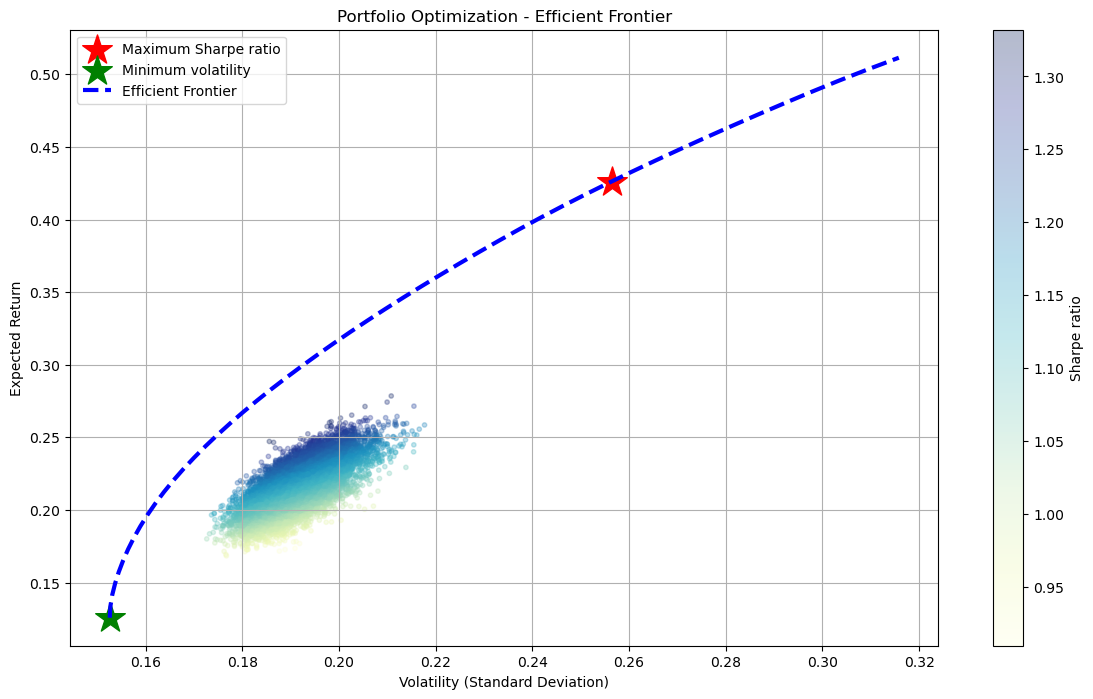

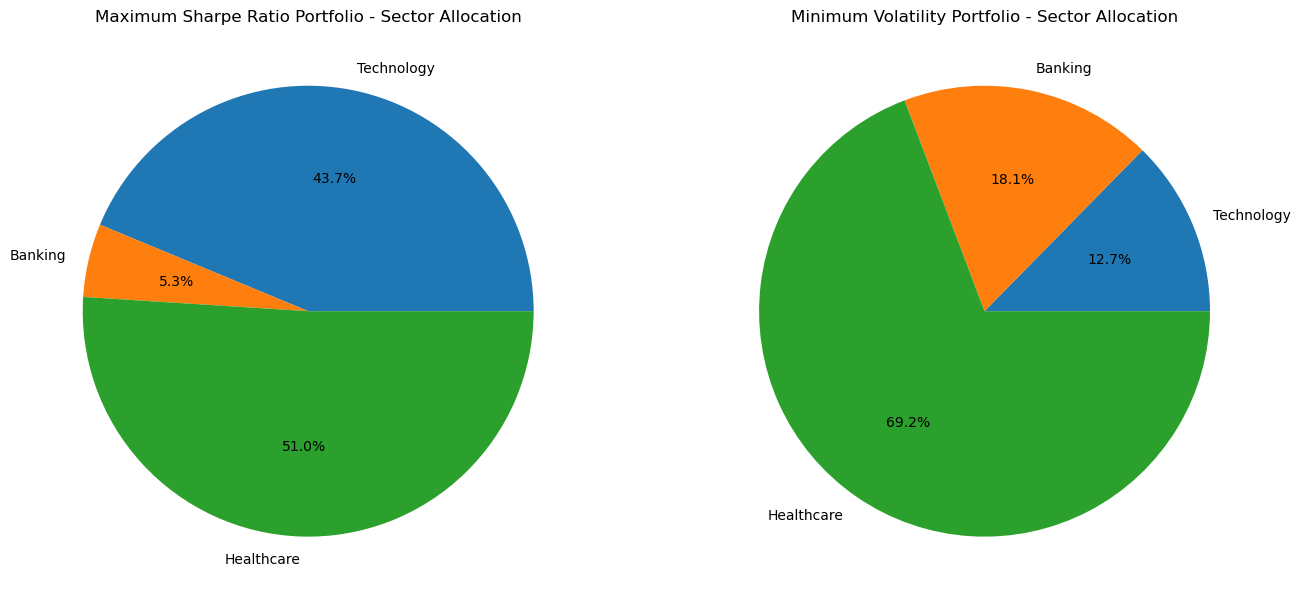

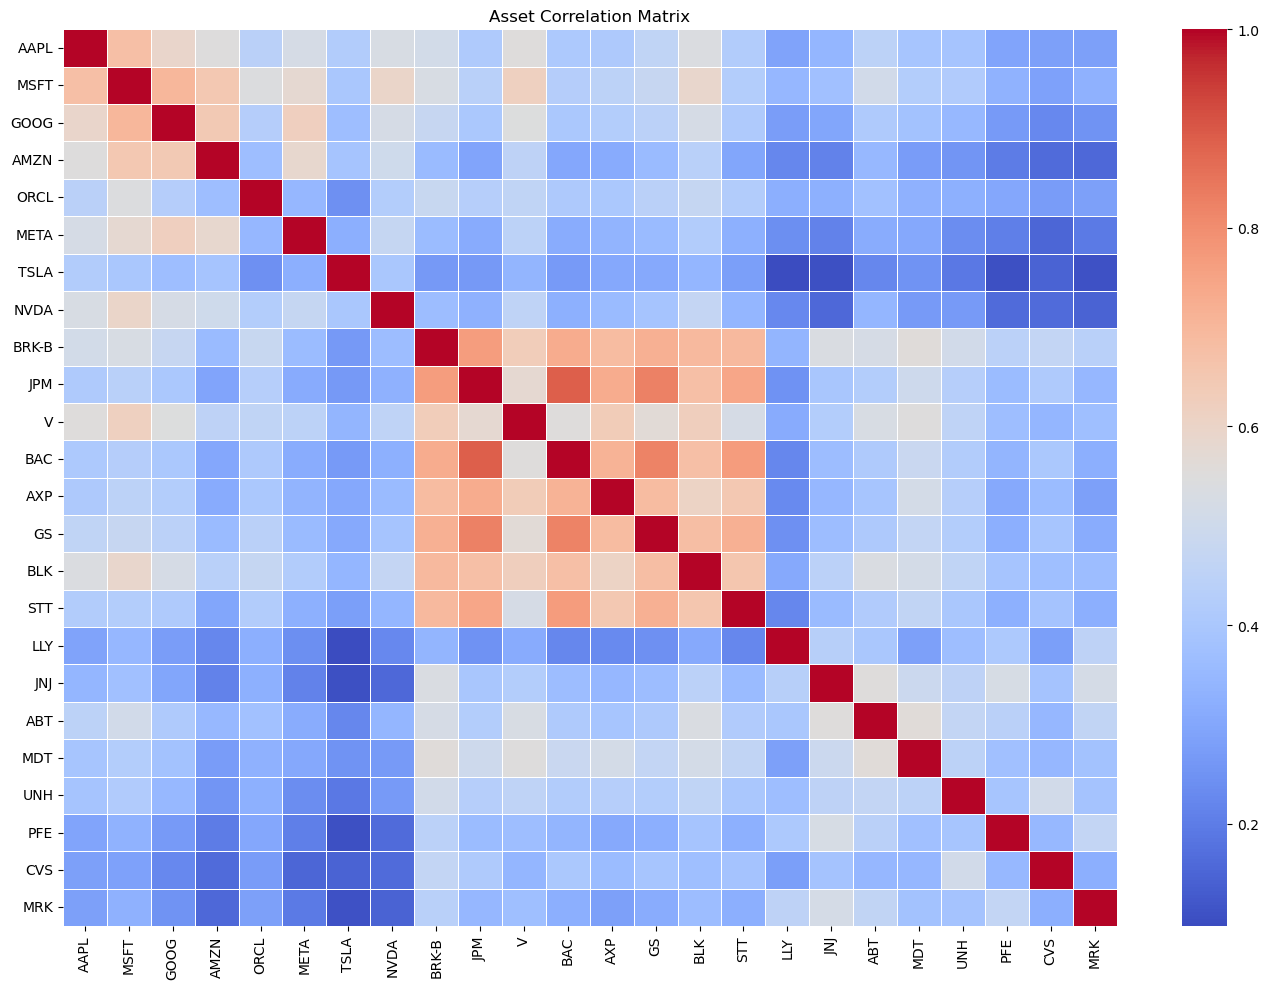

In [25]:
# ENHANCEMENT 7: Visualization of Portfolio Analysis
plt.figure(figsize=(14, 8))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe ratio')
plt.scatter(max_sharpe_volatility, max_sharpe_returns, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
plt.scatter(min_vol_volatility, min_vol_returns, marker='*', color='g', s=500, label='Minimum volatility')

# Plot efficient frontier
target_returns = np.linspace(min_vol_returns, max_sharpe_returns * 1.2, 50)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target_returns)
efficient_volatility = [portfolio_performance(p['x'], mean_returns, cov_matrix)[1] for p in efficient_portfolios]
plt.plot(efficient_volatility, target_returns, 'b--', linewidth=3, label='Efficient Frontier')

plt.title('Portfolio Optimization - Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.savefig('efficient_frontier.png')
plt.show()
plt.close()

# Sector allocation pie charts
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(list(max_sharpe_sectors.values()), labels=list(max_sharpe_sectors.keys()), autopct='%1.1f%%')
plt.title('Maximum Sharpe Ratio Portfolio - Sector Allocation')

plt.subplot(1, 2, 2)
plt.pie(list(min_vol_sectors.values()), labels=list(min_vol_sectors.keys()), autopct='%1.1f%%')
plt.title('Minimum Volatility Portfolio - Sector Allocation')
plt.savefig('sector_allocation.png')
plt.show()
plt.close()

# ENHANCEMENT 8: Correlation Analysis
plt.figure(figsize=(14, 10))
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Asset Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

In [5]:
# ENHANCEMENT 9: Backtesting the Portfolios
def backtest_portfolio(weights, data, start_date=None, end_date=None):
    """Backtest a portfolio with fixed weights"""
    # Filter data by date range if provided
    if start_date is not None and end_date is not None:
        data = data.loc[start_date:end_date]
    
    # Get daily returns
    daily_returns = data.xs('Daily Return', axis=1, level=1)
    
    # Calculate portfolio returns
    portfolio_returns = daily_returns.dot(weights)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # Calculate performance metrics
    annual_return = np.power(cumulative_returns.iloc[-1], 252/len(cumulative_returns)) - 1
    annual_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    
    return {
        'cumulative_returns': cumulative_returns,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

# Define backtesting period (last 3 years)
backtest_start = combined_data.index[-756]  # ~3 years (252 trading days per year)
backtest_end = combined_data.index[-1]

# Backtest optimal portfolios
max_sharpe_backtest = backtest_portfolio(max_sharpe_weights, combined_data, backtest_start, backtest_end)
min_vol_backtest = backtest_portfolio(min_vol_weights, combined_data, backtest_start, backtest_end)

# Backtest equal-weight portfolio for comparison
equal_weights = np.array([1/len(all_assets)] * len(all_assets))
equal_weight_backtest = backtest_portfolio(equal_weights, combined_data, backtest_start, backtest_end)

# Calculate S&P 500 returns for comparison
sp500_returns = sp500_data['Close'].pct_change().dropna()
sp500_returns = sp500_returns.loc[backtest_start:backtest_end]
sp500_cumulative = (1 + sp500_returns).cumprod()

# Plot backtesting results
plt.figure(figsize=(14, 8))
plt.plot(max_sharpe_backtest['cumulative_returns'], label='Max Sharpe Portfolio')
plt.plot(min_vol_backtest['cumulative_returns'], label='Min Volatility Portfolio')
plt.plot(equal_weight_backtest['cumulative_returns'], label='Equal-Weight Portfolio')
plt.plot(sp500_cumulative, label='S&P 500')
plt.title('Portfolio Backtesting Results')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.savefig('backtest_results.png')
plt.close()

# Print backtesting results
print("\nBacktesting Results (Last 3 Years):")
print(f"Max Sharpe Portfolio: Return: {max_sharpe_backtest['annual_return']:.2%}, Volatility: {max_sharpe_backtest['annual_volatility']:.2%}, Sharpe: {max_sharpe_backtest['sharpe_ratio']:.2f}, Max Drawdown: {max_sharpe_backtest['max_drawdown']:.2%}")
print(f"Min Volatility Portfolio: Return: {min_vol_backtest['annual_return']:.2%}, Volatility: {min_vol_backtest['annual_volatility']:.2%}, Sharpe: {min_vol_backtest['sharpe_ratio']:.2f}, Max Drawdown: {min_vol_backtest['max_drawdown']:.2%}")
print(f"Equal-Weight Portfolio: Return: {equal_weight_backtest['annual_return']:.2%}, Volatility: {equal_weight_backtest['annual_volatility']:.2%}, Sharpe: {equal_weight_backtest['sharpe_ratio']:.2f}, Max Drawdown: {equal_weight_backtest['max_drawdown']:.2%}")



Backtesting Results (Last 3 Years):
Max Sharpe Portfolio: Return: 53.26%, Volatility: 27.36%, Sharpe: 1.95, Max Drawdown: -24.73%
Min Volatility Portfolio: Return: 7.39%, Volatility: 13.32%, Sharpe: 0.55, Max Drawdown: -14.62%
Equal-Weight Portfolio: Return: 16.76%, Volatility: 17.84%, Sharpe: 0.94, Max Drawdown: -23.28%


In [7]:
# ENHANCEMENT 11: LSTM Model for Market Prediction
# Prepare data for LSTM
def prepare_lstm_data(data, lookback=50):
    """Prepare data for LSTM model"""
    # Use Close prices for all assets
    X = data.xs('Close', axis=1, level=1)
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(X)
    
    X_lstm, y_lstm = [], []
    for i in range(lookback, len(scaled_data)):
        X_lstm.append(scaled_data[i-lookback:i])
        y_lstm.append(scaled_data[i])
    
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    
    # Split data into train and test sets
    train_size = int(len(X_lstm) * 0.9)
    X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
    y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler, X.columns

# Build LSTM model
def build_lstm_model(input_shape, output_shape):
    """Build LSTM model for time series prediction"""
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dense(output_shape))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data for LSTM
X_train, X_test, y_train, y_test, scaler, feature_names = prepare_lstm_data(combined_data)

# Build and train LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

lstm_model = build_lstm_model(input_shape, output_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=36,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate LSTM model
lstm_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nLSTM Model MSE on Test Data: {lstm_loss:.6f}")

# Make predictions
predictions = lstm_model.predict(X_test)

# Transform predictions and actual values back to original scale
predictions_orig = scaler.inverse_transform(predictions)
y_test_orig = scaler.inverse_transform(y_test)

# Calculate RMSE for each asset
mse = np.mean((predictions_orig - y_test_orig) ** 2, axis=0)
rmse = np.sqrt(mse)

# Plot results for a sample asset (first asset)
sample_asset_idx = 0
sample_asset_name = feature_names[sample_asset_idx]

plt.figure(figsize=(14, 7))
plt.plot(y_test_orig[:, sample_asset_idx], label='Actual')
plt.plot(predictions_orig[:, sample_asset_idx], label='Predicted')
plt.title(f'LSTM Predictions for {sample_asset_name}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig(f'lstm_prediction_{sample_asset_name}.png')
plt.close()

# Print RMSE for each asset
print("\nRoot Mean Squared Error (RMSE) for each asset:")
for i, asset in enumerate(feature_names):
    print(f"{asset}: {rmse[i]:.2f}")

C:\Users\lynch\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 0.0265 - val_loss: 0.0206
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0018 - val_loss: 0.0194
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0013 - val_loss: 0.0153
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 9.2150e-04 - val_loss: 0.0138
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 7.9057e-04 - val_loss: 0.0126
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 8.6246e-04 - val_loss: 0.0128
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 7.5208e-04 - val_loss: 0.0109
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 6.3715e-04 - val_loss: 0.0110
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 6.3719e-04 - val_loss: 0.0111
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 5.4902e-04 - val_loss: 0.0105
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.3631e-04 - val_loss: 0.0101
Epoch 12/50
58/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━

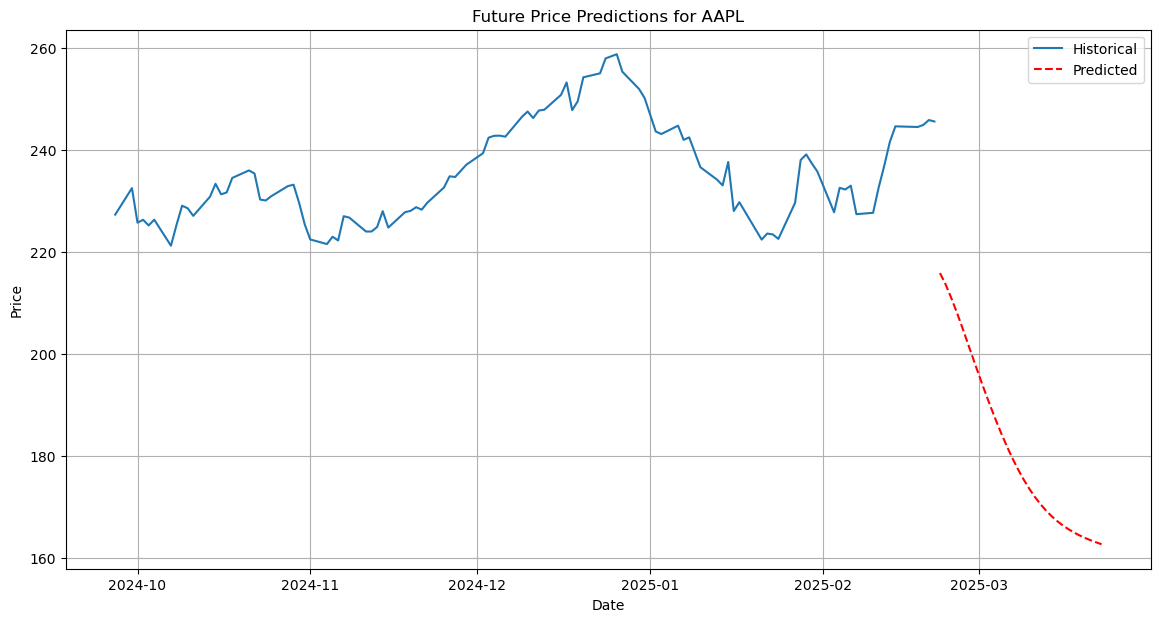

In [9]:
# ENHANCEMENT 12: Make Future Predictions
def make_future_predictions(model, last_sequence, scaler, prediction_days=30):
    """Make future predictions using the trained LSTM model"""
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(prediction_days):
        # Reshape for model input
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        
        # Predict next day
        next_day_prediction = model.predict(current_sequence_reshaped)
        
        # Store prediction
        future_predictions.append(next_day_prediction[0])
        
        # Update sequence (remove first day, add prediction as last day)
        current_sequence = np.append(current_sequence[1:], [next_day_prediction[0]], axis=0)
    
    # Convert predictions to original scale
    future_predictions = np.array(future_predictions)
    future_predictions_orig = scaler.inverse_transform(future_predictions)
    
    return future_predictions_orig

# Get the last sequence from the dataset
last_sequence = X_test[-1]

# Make future predictions
future_days = 30
future_predictions = make_future_predictions(lstm_model, last_sequence, scaler, future_days)

# Create future dates for plotting
last_date = combined_data.index[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(future_days)]

# Plot future predictions for a sample asset
plt.figure(figsize=(14, 7))
plt.plot(combined_data.xs('Close', axis=1, level=1)[sample_asset_name].iloc[-100:].index, 
         combined_data.xs('Close', axis=1, level=1)[sample_asset_name].iloc[-100:].values, 
         label='Historical')
plt.plot(future_dates, future_predictions[:, sample_asset_idx], 'r--', label='Predicted')
plt.title(f'Future Price Predictions for {sample_asset_name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig(f'future_prediction_{sample_asset_name}.png')
plt.show()
plt.close()

In [11]:
# ENHANCEMENT 13: Identify Optimal Asset Allocations for Different Risk Profiles
# Define different risk profiles
risk_profiles = {
    'Conservative': {'target_return': min_vol_returns * 0.8},
    'Moderate': {'target_return': (min_vol_returns + max_sharpe_returns) / 2},
    'Aggressive': {'target_return': max_sharpe_returns * 1.2}
}

# Calculate optimal allocations for each risk profile
risk_profile_portfolios = {}
for profile, params in risk_profiles.items():
    target_return = params['target_return']
    # Find the portfolio with minimum volatility for the target return
    result = min_volatility_for_return(mean_returns, cov_matrix, target_return)
    if result['success']:
        weights = result['x']
        returns, volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        sector_alloc = sector_allocation(weights, sectors)
        risk_profile_portfolios[profile] = {
            'weights': weights,
            'returns': returns,
            'volatility': volatility,
            'sharpe': returns / volatility,
            'sector_allocation': sector_alloc
        }
    else:
        print(f"Optimization failed for {profile} risk profile")

# Print results for each risk profile
print("\nOptimal Portfolios for Different Risk Profiles:")
for profile, portfolio in risk_profile_portfolios.items():
    print(f"\n{profile} Risk Profile:")
    print(f"Expected Annual Return: {portfolio['returns']:.4f}")
    print(f"Annual Volatility: {portfolio['volatility']:.4f}")
    print(f"Sharpe Ratio: {portfolio['sharpe']:.4f}")
    print("Sector Allocation:")
    for sector, allocation in portfolio['sector_allocation'].items():
        print(f"  {sector}: {allocation:.2%}")
    print("Top 5 Assets:")
    top_assets = sorted([(ticker, portfolio['weights'][i]) 
                         for i, ticker in enumerate(all_assets)], 
                        key=lambda x: x[1], reverse=True)[:5]
    for ticker, weight in top_assets:
        print(f"  {ticker}: {weight:.2%}")


Optimal Portfolios for Different Risk Profiles:

Conservative Risk Profile:
Expected Annual Return: 0.1007
Annual Volatility: 0.1547
Sharpe Ratio: 0.6508
Sector Allocation:
  Technology: 4.52%
  Banking: 14.69%
  Healthcare: 80.79%
Top 5 Assets:
  JNJ: 34.87%
  BRK-B: 14.69%
  MRK: 14.50%
  PFE: 11.61%
  MDT: 10.94%

Moderate Risk Profile:
Expected Annual Return: 0.2760
Annual Volatility: 0.1833
Sharpe Ratio: 1.5059
Sector Allocation:
  Technology: 24.93%
  Banking: 15.66%
  Healthcare: 59.40%
Top 5 Assets:
  LLY: 23.95%
  JNJ: 20.29%
  NVDA: 12.64%
  AMZN: 8.80%
  UNH: 8.42%

Aggressive Risk Profile:
Expected Annual Return: 0.5114
Annual Volatility: 0.3158
Sharpe Ratio: 1.6194
Sector Allocation:
  Technology: 58.96%
  Banking: 0.00%
  Healthcare: 41.04%
Top 5 Assets:
  NVDA: 51.66%
  LLY: 41.04%
  TSLA: 7.30%
  BLK: 0.00%
  MDT: 0.00%


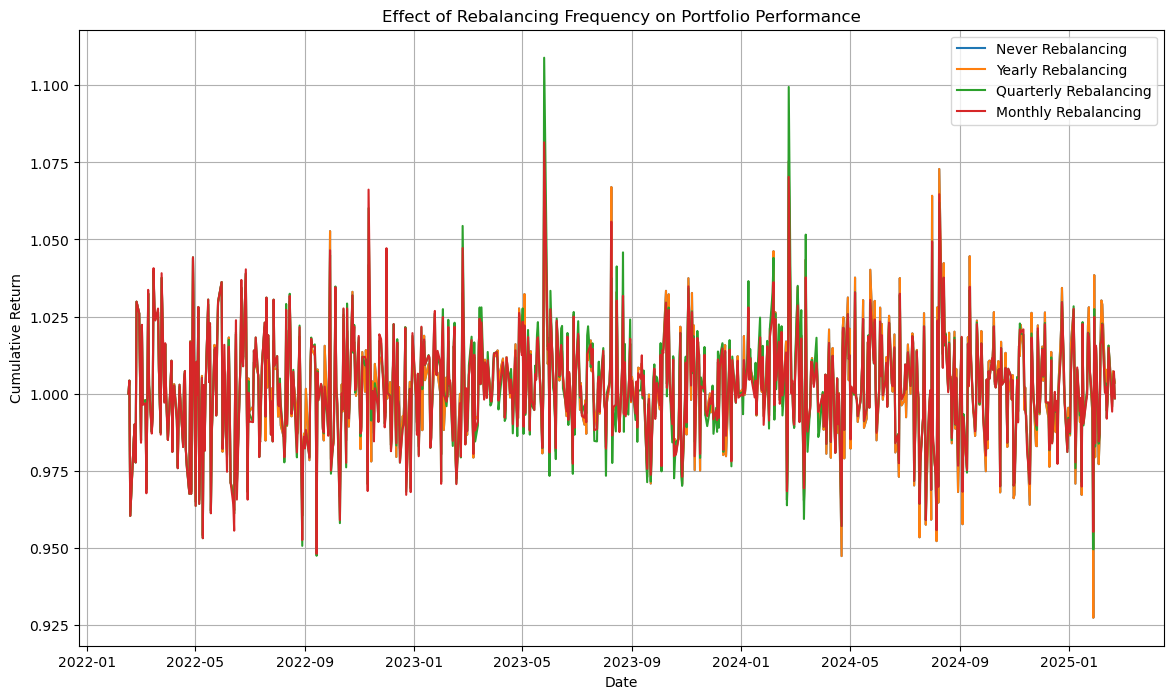


Rebalancing Strategy Comparison (Max Sharpe Portfolio):
Never Rebalancing: Return: 0.12%, Volatility: 39.45%, Sharpe: 0.00, Max Drawdown: -13.77%
Yearly Rebalancing: Return: 0.12%, Volatility: 39.45%, Sharpe: 0.00, Max Drawdown: -13.77%
Quarterly Rebalancing: Return: -0.05%, Volatility: 39.94%, Sharpe: -0.00, Max Drawdown: -14.38%
Monthly Rebalancing: Return: -0.05%, Volatility: 37.97%, Sharpe: -0.00, Max Drawdown: -11.68%


In [13]:
# ENHANCEMENT 14: Portfolio Rebalancing Analysis
# Function to simulate portfolio rebalancing
def portfolio_rebalance_simulation(weights, data, rebalance_frequency, start_date=None, end_date=None):
    """Simulate portfolio performance with periodic rebalancing"""
    # Filter data by date range if provided
    if start_date is not None and end_date is not None:
        data = data.loc[start_date:end_date]
    
    # Get daily returns
    daily_returns = data.xs('Daily Return', axis=1, level=1)
    
    # Initialize portfolio value and weights
    portfolio_value = 1.0
    current_weights = weights.copy()
    portfolio_values = [portfolio_value]
    dates = [data.index[0]]
    
    # Set rebalancing periods
    if rebalance_frequency == 'never':
        # Only rebalance at end date for comparison
        rebalance_periods = pd.DatetimeIndex([data.index[-1]])
    elif rebalance_frequency == 'yearly':
        rebalance_periods = pd.DatetimeIndex(pd.date_range(start=data.index[0], end=data.index[-1], freq='YS'))
        # Add end date if not already included
        rebalance_periods = rebalance_periods.union([data.index[-1]])
    elif rebalance_frequency == 'quarterly':
        rebalance_periods = pd.DatetimeIndex(pd.date_range(start=data.index[0], end=data.index[-1], freq='QS'))
        rebalance_periods = rebalance_periods.union([data.index[-1]])
    elif rebalance_frequency == 'monthly':
        rebalance_periods = pd.DatetimeIndex(pd.date_range(start=data.index[0], end=data.index[-1], freq='MS'))
        rebalance_periods = rebalance_periods.union([data.index[-1]])
    elif rebalance_frequency == 'weekly':
        rebalance_periods = pd.DatetimeIndex(pd.date_range(start=data.index[0], end=data.index[-1], freq='W-MON'))
        rebalance_periods = rebalance_periods.union([data.index[-1]])
    
    # Add end date to rebalancing periods
    rebalance_periods = rebalance_periods.union([data.index[-1]])
    
    # Simulate portfolio value over time
    for i in range(1, len(data)):
        date = data.index[i]
        daily_return = daily_returns.iloc[i-1]
        
        # Update asset values based on returns
        asset_values = current_weights * (1 + daily_return)
        portfolio_value = sum(asset_values)
        
        # Update weights based on new asset values
        current_weights = asset_values / portfolio_value
        
        # Rebalance if this is a rebalancing date
        if date in rebalance_periods:
            current_weights = weights.copy()
        
        portfolio_values.append(portfolio_value)
        dates.append(date)
    
    # Calculate performance metrics
    cumulative_returns = pd.Series(portfolio_values, index=dates)
    annual_return = np.power(cumulative_returns.iloc[-1], 252/len(cumulative_returns)) - 1
    daily_portfolio_returns = cumulative_returns.pct_change().dropna()
    annual_volatility = daily_portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    
    return {
        'cumulative_returns': cumulative_returns,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

# Define rebalancing frequencies to test
rebalance_frequencies = ['never', 'yearly', 'quarterly', 'monthly']

# Simulate rebalancing strategies for max Sharpe portfolio
rebalancing_results = {}
for freq in rebalance_frequencies:
    rebalancing_results[freq] = portfolio_rebalance_simulation(
        max_sharpe_weights, combined_data, freq, backtest_start, backtest_end
    )

# Plot rebalancing results
plt.figure(figsize=(14, 8))
for freq, result in rebalancing_results.items():
    plt.plot(result['cumulative_returns'], label=f'{freq.capitalize()} Rebalancing')
plt.title('Effect of Rebalancing Frequency on Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.savefig('rebalancing_results.png')
plt.show()
plt.close()


# Print rebalancing results
print("\nRebalancing Strategy Comparison (Max Sharpe Portfolio):")
for freq, result in rebalancing_results.items():
    print(f"{freq.capitalize()} Rebalancing: Return: {result['annual_return']:.2%}, Volatility: {result['annual_volatility']:.2%}, Sharpe: {result['sharpe_ratio']:.2f}, Max Drawdown: {result['max_drawdown']:.2%}")



In [19]:
# ENHANCEMENT 15: Summary Report and Recommendations
print("\n=== PORTFOLIO OPTIMIZATION SUMMARY REPORT ===")
print("\nKey Findings:")
print(f"1. Maximum Sharpe Ratio Portfolio has expected annual return of {max_sharpe_returns:.2%} with volatility of {max_sharpe_volatility:.2%}")
print(f"2. Minimum Volatility Portfolio has expected annual return of {min_vol_returns:.2%} with volatility of {min_vol_volatility:.2%}")

# Diagnostic printing
print(f"Type of returns: {type(returns)}")
if isinstance(returns, (float, np.float64)):
    print("returns is a scalar value, not a DataFrame")
    # Need to re-extract the returns data from your original source
    returns = combined_data.xs('Daily Return', axis=1, level=1)
    print(f"Type after correction: {type(returns)}")
    print(f"Shape after correction: {returns.shape}")

# Identify top performing assets
top_performers = mean_returns.sort_values(ascending=False).head(5)
print("\nTop Performing Assets (Expected Annual Return):")
for ticker, ret in top_performers.items():
    print(f"  {ticker}: {ret*252:.2%}")

# Identify assets with lowest volatility
# Make sure we're getting a Series of standard deviations per asset
asset_volatility = pd.Series()
for col in returns.columns:
    asset_volatility[col] = returns[col].std()
    
# Now sort and get the 5 lowest volatility assets
lowest_vol = asset_volatility.sort_values().head(5)
print("\nLowest Volatility Assets:")
for ticker, vol in lowest_vol.items():
    print(f"  {ticker}: {vol*np.sqrt(252):.2%}")  # Annualize the volatility

# Make recommendations based on LSTM predictions
future_returns = (future_predictions[-1] / future_predictions[0]) - 1
top_predicted_performers = [(feature_names[i], future_returns[i]) 
                           for i in range(len(feature_names))]
top_predicted_performers.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 Assets by 30-Day LSTM Predicted Return:")
for ticker, predicted_return in top_predicted_performers[:5]:
    print(f"  {ticker}: {predicted_return:.2%}")

# Overall recommendations
print("\nRecommendations:")
print("1. For conservative investors: Consider the Minimum Volatility Portfolio")
print("2. For balanced investors: Consider the Maximum Sharpe Ratio Portfolio")
print("3. For aggressive investors: Consider a portfolio weighted towards the top LSTM-predicted performers")
print(f"4. Optimal rebalancing frequency based on backtesting: {max(rebalancing_results.items(), key=lambda x: x[1]['sharpe_ratio'])[0].capitalize()}")

# Create 2nd correlation matrix with a different name
correlation_matrix2 = returns.corr()

print("\nPortfolio Diversification Analysis:")
correlation_levels = {
    'High Correlation (>0.7)': [],
    'Moderate Correlation (0.4-0.7)': [],
    'Low Correlation (<0.4)': []
}
for i, asset1 in enumerate(all_assets):
    for j, asset2 in enumerate(all_assets):
        if i < j:  # Avoid duplicate pairs
            corr = correlation_matrix2.loc[asset1, asset2]  # Use the new matrix name here
            pair = f"{asset1}-{asset2}"
            if corr > 0.7:
                correlation_levels['High Correlation (>0.7)'].append((pair, corr))
            elif corr > 0.4:
                correlation_levels['Moderate Correlation (0.4-0.7)'].append((pair, corr))
            else:
                correlation_levels['Low Correlation (<0.4)'].append((pair, corr))

print("\nAsset Correlation Summary:")
for level, pairs in correlation_levels.items():
    print(f"{level}: {len(pairs)} pairs")
    # Print top 3 examples of each correlation level
    for pair, corr in sorted(pairs, key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {pair}: {corr:.2f}")

print("\n=== END OF REPORT ===")

# Save the trained LSTM model and important results
lstm_model.save('stock_lstm_model.keras')

# Save portfolios data
portfolio_data = {
    'max_sharpe': {
        'weights': max_sharpe_weights,
        'returns': max_sharpe_returns,
        'volatility': max_sharpe_volatility,
        'sharpe_ratio': max_sharpe_returns / max_sharpe_volatility,
        'sector_allocation': max_sharpe_sectors
    },
    'min_vol': {
        'weights': min_vol_weights,
        'returns': min_vol_returns,
        'volatility': min_vol_volatility,
        'sharpe_ratio': min_vol_returns / min_vol_volatility,
        'sector_allocation': min_vol_sectors
    },
    'risk_profiles': risk_profile_portfolios
}

# Convert to DataFrame for easy storage
portfolio_weights_df = pd.DataFrame({
    'Asset': all_assets,
    'Max_Sharpe_Weight': max_sharpe_weights,
    'Min_Vol_Weight': min_vol_weights
})


# Save to CSV
portfolio_weights_df.to_csv('portfolio_weights.csv', index=False)

print("Analysis complete! Check the generated charts and CSV files for detailed results.")


=== PORTFOLIO OPTIMIZATION SUMMARY REPORT ===

Key Findings:
1. Maximum Sharpe Ratio Portfolio has expected annual return of 42.62% with volatility of 25.64%
2. Minimum Volatility Portfolio has expected annual return of 12.58% with volatility of 15.26%
Type of returns: <class 'pandas.core.frame.DataFrame'>

Top Performing Assets (Expected Annual Return):
  NVDA: 67.66%
  TSLA: 46.07%
  LLY: 31.25%
  AMZN: 30.97%
  META: 28.66%

Lowest Volatility Assets:
  JNJ: 18.03%
  BRK-B: 19.18%
  MRK: 21.74%
  MDT: 22.97%
  PFE: 23.04%

Top 5 Assets by 30-Day LSTM Predicted Return:
  PFE: 26.85%
  CVS: 4.70%
  JNJ: -0.51%
  MDT: -5.74%
  ABT: -6.20%

Recommendations:
1. For conservative investors: Consider the Minimum Volatility Portfolio
2. For balanced investors: Consider the Maximum Sharpe Ratio Portfolio
3. For aggressive investors: Consider a portfolio weighted towards the top LSTM-predicted performers
4. Optimal rebalancing frequency based on backtesting: Never

Portfolio Diversification An